In [1]:
import numpy as np
import rebound as rb
import matplotlib.pyplot as plt
import sys
%matplotlib inline

In [2]:
from celmech.nbody_simulation_utilities import get_canonical_heliocentric_orbits
from celmech.nbody_simulation_utilities import get_simarchive_integration_results
from celmech import ResonanceEquations

The 'AveragedReducedResonantHamiltonian' provides a class, ResonanceEquations, for modeling the averaved equtions of motion describing the dynamics of a mean motion resonance between two massive, inclinded planetary bodies orbiting a central star. The underlying equations are described [here](https://www.overleaf.com/read/shctxrxcvdpt). This notebook demonstrates how the 'ResonanceEquations' can be used to integrate the equations of motion and compare them with $N$-body integrations.

# set-up

Get an object to model the equations of motion for a 3:2 mean motion resonance.

In [3]:
res_eqs = ResonanceEquations(3,1)

Set up a pair planets near a 3:2 MMR. 

A rebound simulation is used to specify the intial conditions of the planets

In [51]:
def get_sim(res_eqs,Delta,z1,z2,theta1,theta2):
    mstar = 1
    a1 = 1
    a2 = (1+Delta)**(+2/3)  / res_eqs.alpha
    e1,e2 = np.abs([z1,z2])
    pomega1,pomega2 = np.angle([z1,z2])
    lmbda2 = 0
    lmbda1 = (res_eqs.j * lmbda2 - res_eqs.k * pomega1 - theta1) / (res_eqs.j-res_eqs.k)
    sim = rb.Simulation()
    sim.add(m=mstar)
    sim.add(m=res_eqs.m1,a=a1,e=e1,l=lmbda1,pomega=pomega1)
    sim.add(m=res_eqs.m2,a=a2,e=e2,l=lmbda2,pomega=pomega2)
    sim.move_to_com()
    return sim

In [61]:
sim = get_sim(res_eqs,0.0025,0.06,-0.08,np.pi/2,3*np.pi/2)

Generate a set of dynamical variables (`dyvars`) of the resonant equations of motion that correspond to the initial conditions of the $N$-body simulation

In [62]:
dyvars = res_eqs.dyvars_from_rebound_simulation(sim,iIn=1,iOut=2)

# A new simulation is generated from the dynamical variables.
# The newly-generated simulation can differ from the initial rebound
# simulation in two (dynamically unimportant) ways: 
# (1) the scale of the planets' semi-major axes may change
#
# (2) The coordinate system of the new simulation places the z-axis 
#    along the direction of the total angular momentum
#

sim = res_eqs.dyvars_to_rebound_simulation(dyvars,osculating_correction=False)
orbits = get_canonical_heliocentric_orbits(sim)

# Integration

Integrate the resonace equations of motion.

In [63]:
soln = res_eqs.integrate_initial_conditions(dyvars,np.linspace(0,1e4,512))
els_res_eqs = soln['orbital_elements']

Integrate corresponding full $N$-body equations

In [64]:
nbtimes = els_res_eqs['times'] 
sim.automateSimulationArchive("./sa.bin",interval=nbtimes[1]-nbtimes[0],deletefile=True)
sim.integrate(nbtimes[-1])

In [65]:
sa = rb.SimulationArchive("./sa.bin")
nb_result = get_simarchive_integration_results(sa,coordinates='heliocentric')

# Process and plot results

In [58]:
# Measure resonant angles from n-body simulation
nb_result['theta'] = np.array([res_eqs.k - res_eqs.j,res_eqs.j]) @ nb_result['l'] - nb_result['pomega']
nb_result['theta'] = np.mod(nb_result['theta'],2*np.pi)

# Take angles modulo 2-pi
els_res_eqs['theta1'] = np.mod(els_res_eqs['theta1']  ,2*np.pi)
els_res_eqs['theta2'] = np.mod(els_res_eqs['theta2']  ,2*np.pi)


In [59]:
# Process n-body dictionary to match notation used in dictionary containing
# analytic results
nb_results_by_planet = {}
for key,val in nb_result.items():
    if val.ndim>1:
        for i,quantity in enumerate(val):
            nb_results_by_planet["{:s}{:d}".format(key,i+1)] = quantity
    else:
        nb_results_by_planet[key] = val

Plot results

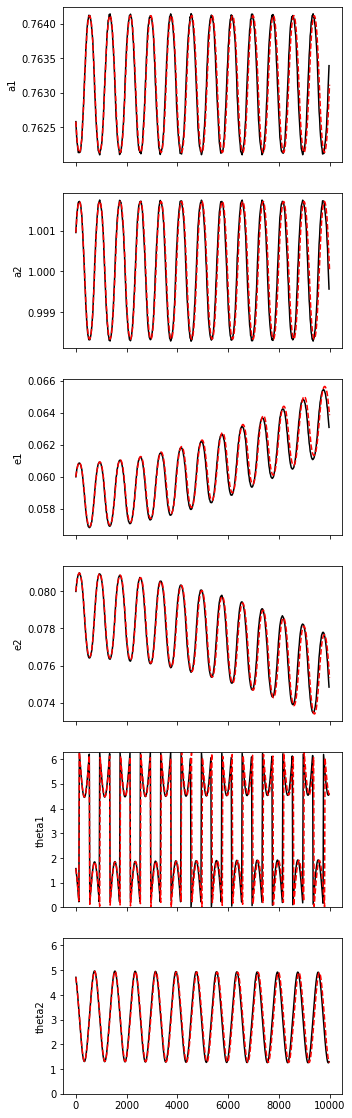

In [60]:
fig,axes = plt.subplots(len(els_res_eqs)-1,1,sharex=True,figsize=(5,20))
time1 = els_res_eqs['times']
time2 = nb_results_by_planet['time']
for i,key in enumerate(els_res_eqs.keys()):
    if key=='times':
        continue
    ax = axes[i]
    ax.plot(time2,nb_results_by_planet[key],'k-')
    ax.plot(time1,els_res_eqs[key],'r--')
    ax.set_ylabel(key)
    if key[0] is 't':
        ax.set_ylim(0,2*np.pi)

# Fixed point determination

The 'ResonanceEquations' class can be used to determine equlibrium configurations of the dynamical equations of motion.

In [40]:
np.random.seed(1)
mstar = 1
m1=1e-5
m2=1e-5
a1 = 1
Delta = 0.00025
a2 = (1+Delta)**(+2/3)  / res_eqs.alpha
inc1 = 0.0
inc2 = 0
z = np.random.uniform(0,2*np.pi,2)
z1,z2 = 0.08,-0.08
e1,e2 = np.abs([z1,z2])
pomega1,pomega2 = np.angle([z1,z2])
theta1 = 0
theta2 = np.pi
lmbda2 = 0
lmbda1 = (res_eqs.j * lmbda2 - res_eqs.k * pomega1 - theta1) / (res_eqs.j-res_eqs.k)
# Omega1  = np.random.uniform(0,2*np.pi)
# Omega2 = Omega1 + np.pi
sim = rb.Simulation()
sim.add(m=mstar)
sim.add(m=m1,a=a1,e=e1,inc=inc1,l=lmbda1,pomega=pomega1)
sim.add(m=m2,a=a2,e=e2,inc=inc2,l=lmbda2,pomega=pomega2)
sim.move_to_com()
dyvars = res_eqs.dyvars_from_rebound_simulation(sim)

In [70]:
# get a new sim near the guessed equilibrium
sim = get_sim(res_eqs,0.0025,0.08,-0.08,0,np.pi)
dyvars = res_eqs.dyvars_from_rebound_simulation(sim)

In [71]:
eq_dyvars = res_eqs.find_equilibrium(dyvars)
sim = res_eqs.dyvars_to_rebound_simulation(eq_dyvars,osculating_correction=False)

nbtimes = els_res_eqs['times'] 
sim.automateSimulationArchive("./eq_sa.bin",interval=nbtimes[1]-nbtimes[0],deletefile=True)
sim.integrate(nbtimes[-1])

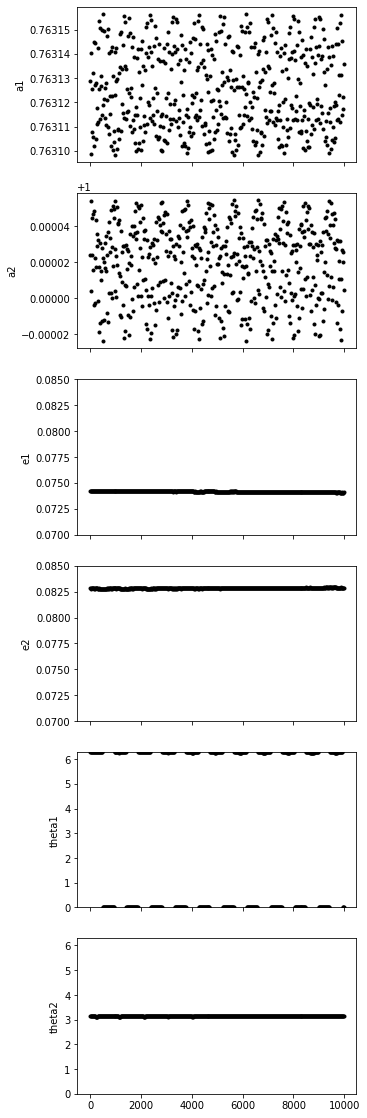

In [72]:
sa = rb.SimulationArchive("./eq_sa.bin")
nb_result = get_simarchive_integration_results(sa,coordinates='heliocentric')

# Process n-body dictionary to match notation used in dictionary containing
# analytic results
# Measure resonant angles from n-body simulation
nb_result['theta'] = np.array([res_eqs.k - res_eqs.j,res_eqs.j]) @ nb_result['l'] - nb_result['pomega']
nb_result['theta'] = np.mod(nb_result['theta'],2*np.pi)


nb_results_by_planet = {}
for key,val in nb_result.items():
    if val.ndim>1:
        for i,quantity in enumerate(val):
            nb_results_by_planet["{:s}{:d}".format(key,i+1)] = quantity
    else:
        nb_results_by_planet[key] = val

fig,axes = plt.subplots(len(els_res_eqs)-1,1,sharex=True,figsize=(5,20))
time2 = nb_results_by_planet['time']
for i,key in enumerate(els_res_eqs.keys()):
    if key=='times':
        continue
    ax = axes[i]
    ax.plot(time2,nb_results_by_planet[key],'k.')
    ax.set_ylabel(key)
    if key[0] is 't':
        ax.set_ylim(0,2*np.pi)
    elif key[0] is 'e':
        ax.set_ylim(0.07,0.085)